<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Scalograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Escalogramas de señales ferroviarias con defectos**
Simulación de N señales acelerométricas (1s) y cálculo de sus escalogramas CWT normalizados.

- n1 señales "sanas" (baseline vibratorio)
- n2 con "corrugación" (componente ~110–130 Hz)
- n3 con "stud" (juntas/defectos repetidos)
- n4 con "squats" (~780–820 Hz) tipo pinned–pinned

Cada señal: 2 s @ 5 kHz. CWT con wavelet Morlet.

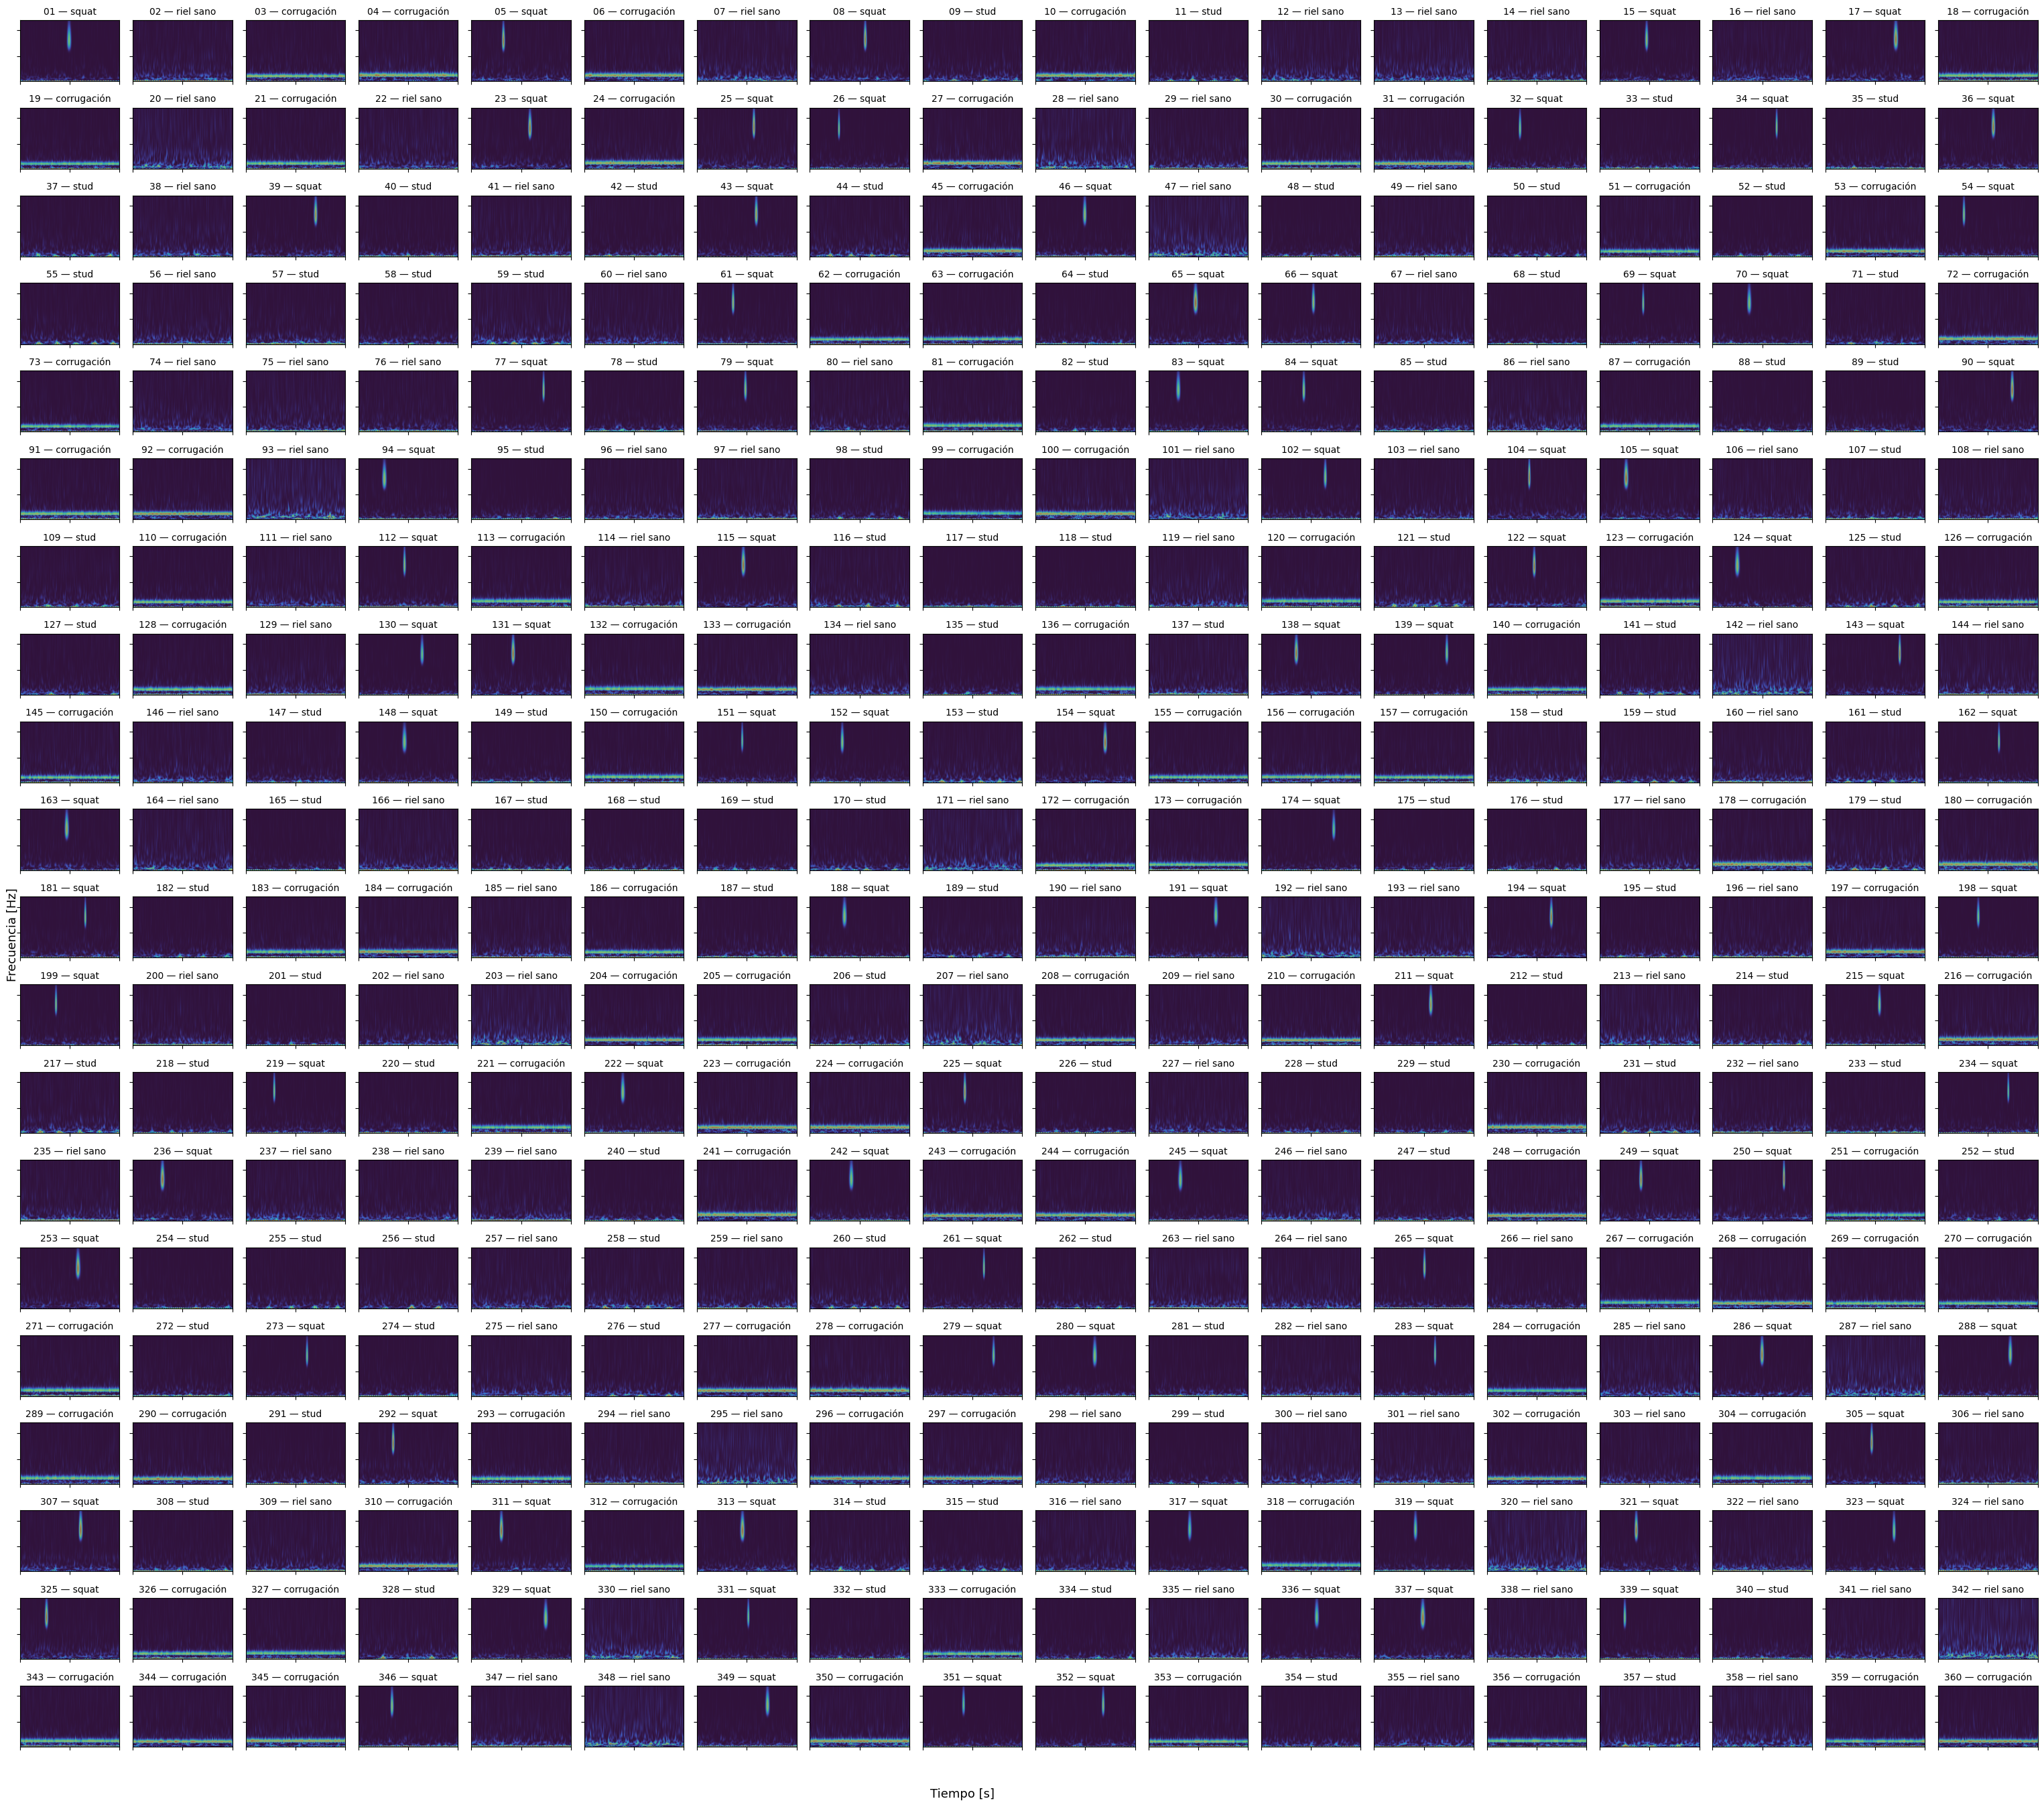

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

# Intentar usar PyWavelets (Morlet). Si no está, usar SciPy (Ricker) como respaldo.
try:
    import pywt
    HAVE_PYWT = True
except Exception:
    from scipy.signal import cwt, ricker
    HAVE_PYWT = False

# -----------------------------
# Parámetros principales
# -----------------------------
rng = np.random.default_rng(42)  # Semilla para reproducibilidad
N_SCALOGRAMS = 360     # Número de escalogramas simulados
fs = 5000.0            # Hz
T = 1.0                # duración de cada señal (s)
N = int(T * fs)
MAX_COLS = 36          # número máximo de columnas en la rejilla
COLORMAP = "turbo"     # colormap más "colorido"

# -----------------------------
# Utilidades para síntesis
# -----------------------------
def gaussian_pulse(t, t0, sigma, amp=1.0):
    return amp * np.exp(-0.5 * ((t - t0) / sigma) ** 2)

def gabor_burst(t, t0, f0, dur, amp=1.0):
    sigma = dur / 6.0
    env = np.exp(-0.5 * ((t - t0) / sigma) ** 2)
    return amp * env * np.sin(2 * np.pi * f0 * (t - t0))

def ar1_noise(size, alpha=0.95, scale=0.03, seed=None):
    r = np.random.default_rng(seed)
    e = r.normal(scale=scale, size=size)
    x = np.zeros_like(e)
    for i in range(1, size):
        x[i] = alpha * x[i-1] + e[i]
    return x

def multi_sine_noise(t, k=12, fmin=40, fmax=1200, amin=0.005, amax=0.02, seed=None):
    r = np.random.default_rng(seed)
    out = np.zeros_like(t)
    for _ in range(k):
        a = r.uniform(amin, amax)
        f = r.uniform(fmin, fmax)
        ph = r.uniform(0, 2*np.pi)
        out += a * np.sin(2*np.pi*f*t + ph)
    return out

# -----------------------------
# Generadores de señales
# -----------------------------
def simulate_signal(kind, t, fs, seed=None):
    rlocal = np.random.default_rng(seed)
    base_f = rlocal.uniform(8.0, 30.0)
    sig = 0.25 * np.sin(2 * np.pi * base_f * t)

    # Más ruido y textura para escalogramas "coloridos"
    sig += rlocal.normal(scale=0.12, size=t.size)              # ruido blanco
    sig += ar1_noise(t.size, alpha=0.92, scale=0.03, seed=seed) # ruido AR(1) (coloreado)
    sig += multi_sine_noise(t, k=14, seed=seed)                 # suma de senos débiles

    # Microvariaciones
    sig += 0.05 * np.sin(2 * np.pi * rlocal.uniform(35, 70) * t + rlocal.uniform(0, 2*np.pi))
    sig += 0.03 * np.sin(2 * np.pi * rlocal.uniform(70, 140) * t + rlocal.uniform(0, 2*np.pi))

    if kind == "riel_sano":
        pass  # ya tiene ruido y componentes suaves

    elif kind == "corrugación":
        f_corr = rlocal.uniform(110, 130)
        sig += 0.35 * np.sin(2 * np.pi * f_corr * t)

    elif kind == "stud":
        period = rlocal.uniform(0.18, 0.32)
        for t0 in np.arange(period, T + 1e-9, period):
            sig += gaussian_pulse(t, t0, sigma=0.004, amp=0.7)

    elif kind == "squat":
        f0 = rlocal.uniform(780, 820)
        t0 = rlocal.uniform(0.25, 0.75)   # en 1 s, centrar ráfaga
        dur = rlocal.uniform(0.04, 0.08)
        sig += gabor_burst(t, t0, f0, dur, amp=1.2)
        for _ in range(rlocal.integers(1, 3)):
            sig += gaussian_pulse(t, rlocal.uniform(0.1, 0.9), sigma=0.003, amp=0.3)
    else:
        raise ValueError("Tipo no reconocido")

    # Normalización de amplitud de la señal para evitar saturación
    maxabs = np.max(np.abs(sig))
    if maxabs > 0:
        sig = sig / (1.2 * maxabs)
    return sig.astype(np.float32)

# -----------------------------
# CWT (escalogramas)
# -----------------------------
def compute_cwt(signal, fs, use_log_power=True):
    if HAVE_PYWT:
        freqs = np.linspace(20, 1200, 256)  # banda de interés
        fc = pywt.central_frequency('morl')
        scales = fc * fs / freqs
        coef, _ = pywt.cwt(signal, scales, 'morl', sampling_period=1.0/fs)
        power = np.abs(coef) ** 2
    else:
        widths = np.linspace(1, 250, 250)
        coef = cwt(signal, ricker, widths)
        freqs = fs / (2 * np.pi * widths)  # pseudo-frecuencia
        power = np.abs(coef) ** 2

    if use_log_power:
        power = np.log1p(power)

    # Normalización por escalograma a [0,1]
    pmin = power.min()
    pmax = power.max()
    power = (power - pmin) / (pmax - pmin + 1e-12)
    return power.astype(np.float32), freqs

# -----------------------------
# Armado del conjunto de N señales
# -----------------------------
def balanced_labels(n):
    kinds = ["riel_sano", "corrugación", "stud", "squat"]
    base = n // len(kinds)
    rem = n % len(kinds)
    counts = [base] * len(kinds)
    for i in range(rem):
        counts[i] += 1
    labels = []
    for k, c in zip(kinds, counts):
        labels += [k] * c
    rng.shuffle(labels)
    return labels

t = np.arange(N) / fs
labels = balanced_labels(N_SCALOGRAMS)

signals = []
scalograms = []
freq_axis = None

for i, kind in enumerate(labels):
    sig = simulate_signal(kind, t, fs, seed=1000 + i)
    power, freqs = compute_cwt(sig, fs, use_log_power=True)
    signals.append(sig)
    scalograms.append(power)
    if freq_axis is None:
        freq_axis = freqs

# -----------------------------
# Malla y visualización
# -----------------------------
def grid_dims(n, max_cols=MAX_COLS):
    cols = min(max_cols, int(np.ceil(np.sqrt(n))))
    rows = int(np.ceil(n / cols))
    return rows, cols

rows, cols = grid_dims(N_SCALOGRAMS, MAX_COLS)
fig_w = 1.8 * cols
fig_h = 1.4 * rows
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)  # manejar el caso de 1 fila/columna
extent = (0, T, float(freq_axis.min()), float(freq_axis.max()))

for idx in range(rows * cols):
    ax = axes[idx]
    if idx < N_SCALOGRAMS:
        power = scalograms[idx]
        kind = labels[idx]
        ax.imshow(power, extent=extent, origin='lower', aspect='auto', vmin=0.0, vmax=1.0, cmap=COLORMAP)
        ax.set_title(f"{idx+1:02d} — {kind.replace('_', ' ')}", fontsize=10)
    else:
        ax.axis("off")

# Etiquetas comunes y estilo
for i, ax in enumerate(axes[:N_SCALOGRAMS]):
    if i // cols < rows - 1:
        ax.set_xticklabels([])
    if i % cols != 0:
        ax.set_yticklabels([])

fig.text(0.5, 0.04, "Tiempo [s]", ha="center", fontsize=13)
fig.text(0.06, 0.5, "Frecuencia [Hz]", va="center", rotation="vertical", fontsize=13)
plt.tight_layout(rect=[0.06, 0.06, 1, 1])
plt.show()

# Objetos útiles en memoria:
# - 'signals'      -> lista de N señales 1D (float32, 1 s @ 5 kHz)
# - 'scalograms'   -> lista de N matrices normalizadas en [0,1] (freq x tiempo)
# - 'labels'       -> etiquetas simuladas para diagnóstico/validación
